In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/utkface-new/UTKFace/26_0_2_20170104023102422.jpg.chip.jpg
/kaggle/input/utkface-new/UTKFace/22_1_1_20170112233644761.jpg.chip.jpg
/kaggle/input/utkface-new/UTKFace/21_1_3_20170105003215901.jpg.chip.jpg
/kaggle/input/utkface-new/UTKFace/28_0_0_20170117180555824.jpg.chip.jpg
/kaggle/input/utkface-new/UTKFace/17_1_4_20170103222931966.jpg.chip.jpg
/kaggle/input/utkface-new/UTKFace/44_0_3_20170119201022260.jpg.chip.jpg
/kaggle/input/utkface-new/UTKFace/35_0_2_20170116182734834.jpg.chip.jpg
/kaggle/input/utkface-new/UTKFace/76_0_0_20170104213515132.jpg.chip.jpg
/kaggle/input/utkface-new/UTKFace/36_1_0_20170116165722892.jpg.chip.jpg
/kaggle/input/utkface-new/UTKFace/34_0_3_20170119200815948.jpg.chip.jpg
/kaggle/input/utkface-new/UTKFace/18_1_0_20170104022856102.jpg.chip.jpg
/kaggle/input/utkface-new/UTKFace/40_1_1_20170113011948248.jpg.chip.jpg
/kaggle/input/utkface-new/UTKFace/45_0_0_20170117180013541.jpg.chip.jpg
/kaggle/input/utkface-new/UTKFace/26_1_1_20170117153641469.jpg.c

# Importing the Libraries

In [2]:
import pandas as pd
import os
import numpy as np
import seaborn as sns
import warnings
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')
%matplotlib inline

import tensorflow as tf
from keras.preprocessing.image import load_img
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Input


# Load the dataset

In [3]:
DIR = '/kaggle/input/utkface-new/UTKFace/'

In [4]:
# get labels, age and gender
image_pths = []
age_labels = []
gender_labels = []

for filename in tqdm(os.listdir(DIR)):
    img_path = os.path.join(DIR,filename)
    temp = filename.split('_')
    #print(temp)
    age = int(temp[0])
    gender = int(temp[1])
    image_pths.append(img_path)
    age_labels.append(age)
    gender_labels.append(gender)


  0%|          | 0/23708 [00:00<?, ?it/s]

In [5]:
df = pd.DataFrame()
df['Image'], df['Age'], df['Gender'] = image_pths, age_labels, gender_labels

In [6]:
df.head()

Image  Age  Gender
0  /kaggle/input/utkface-new/UTKFace/26_0_2_20170...   26       0
1  /kaggle/input/utkface-new/UTKFace/22_1_1_20170...   22       1
2  /kaggle/input/utkface-new/UTKFace/21_1_3_20170...   21       1
3  /kaggle/input/utkface-new/UTKFace/28_0_0_20170...   28       0
4  /kaggle/input/utkface-new/UTKFace/17_1_4_20170...   17       1

In [7]:
# creating a gender dictionary
gender_dict = {0:'Male',1:'Female'}

# Exploratory Data Analysis

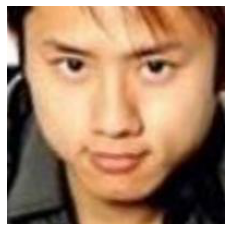

In [8]:
from PIL import Image
img = Image.open(df['Image'][0])
plt.axis('off')
plt.imshow(img);

<AxesSubplot:xlabel='Age', ylabel='Density'>

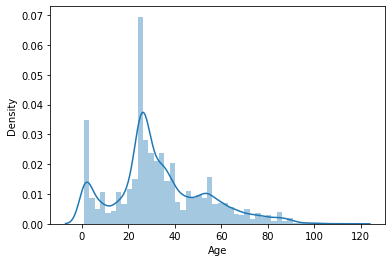

In [9]:
sns.distplot(df['Age']) 

In [10]:
df.describe()

Age        Gender
count  23708.000000  23708.000000
mean      33.303484      0.477349
std       19.886112      0.499497
min        1.000000      0.000000
25%       23.000000      0.000000
50%       29.000000      0.000000
75%       45.000000      1.000000
max      116.000000      1.000000

<AxesSubplot:xlabel='Gender', ylabel='count'>

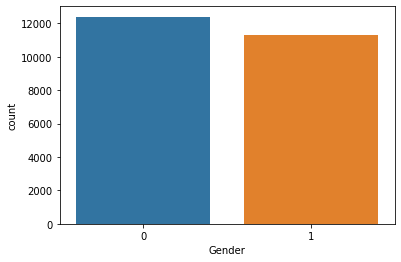

In [11]:
sns.countplot(df['Gender'])

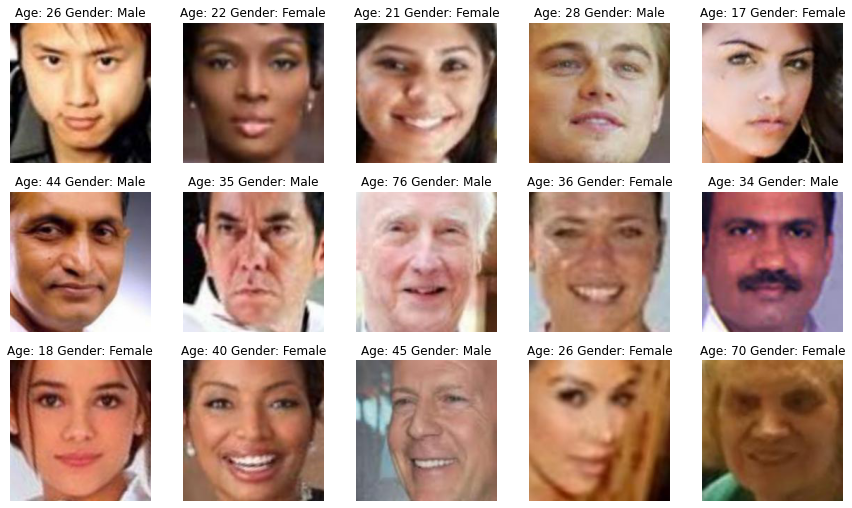

In [12]:
plt.figure(figsize=(15,15))
files = df.iloc[0:15]

for index, file, age, gender in files.itertuples():
    plt.subplot(5,5,index+1)
    img = load_img(file)
    img = np.array(img)
    plt.imshow(img);
    plt.title(f"Age: {age} Gender: {gender_dict[gender]}")
    plt.axis('off')


# Feature Extraction

In [13]:
def extract_features(images):
    features = []
    for image in tqdm(images):
        img = load_img(image)
        img = img.resize((75,75),Image.ANTIALIAS)
        img = np.array(img)
        features.append(img)
    features = np.array(features)
    #features = features.reshape(len(features),128,128,1) # only for grayscale no need if RGB is used
    return features

In [14]:
X = extract_features(df['Image'])

  0%|          | 0/23708 [00:00<?, ?it/s]

In [15]:
print(X.shape)

(23708, 75, 75, 3)


In [16]:
# Normalize the images
X = X/255.0

In [17]:
y_gender = np.array(df['Gender'])
y_age = np.array(df['Age'])

In [18]:
input_shape = (75,75,3)
n_classes = 1


# Model Creation

In [29]:
gender_model = Sequential()
gender_model.add(Conv2D(32,kernel_size=(3,3),activation='relu',input_shape=input_shape,name='gender-conv-1'))
gender_model.add(MaxPooling2D((2,2),name='gender-maxpool-1'))
gender_model.add(Conv2D(64,kernel_size=(3,3),activation='relu',name='gender-conv-2'))
gender_model.add(MaxPooling2D((2,2),name='gender-maxpool-2'))
gender_model.add(Conv2D(128,kernel_size=(3,3),activation='relu',name='gender-conv-3'))
gender_model.add(MaxPooling2D((2,2),name='gender-maxpool-3'))
gender_model.add(Conv2D(256,kernel_size=(3,3),activation='relu',name='gender-conv-4'))
gender_model.add(MaxPooling2D((2,2),name='gender-maxpool-4'))
gender_age_model.add(Flatten(name='gender-flatten-1'))

gender_model.add(Dense(256,activation='relu',name='gender-dense-1'))
gender_model.add(Dropout(0.3,name='gender-fc-dropout-1'))
gender_model.add(Dense(1,activation='sigmoid',name='gender-output'))
gender_model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gender-conv-1 (Conv2D)       (None, 73, 73, 32)        896       
_________________________________________________________________
gender-maxpool-1 (MaxPooling (None, 36, 36, 32)        0         
_________________________________________________________________
gender-conv-2 (Conv2D)       (None, 34, 34, 64)        18496     
_________________________________________________________________
gender-maxpool-2 (MaxPooling (None, 17, 17, 64)        0         
_________________________________________________________________
gender-conv-3 (Conv2D)       (None, 15, 15, 128)       73856     
_________________________________________________________________
gender-maxpool-3 (MaxPooling (None, 7, 7, 128)         0         
_________________________________________________________________
gender-conv-4 (Conv2D)       (None, 5, 5, 256)       

In [44]:
import keras
    
inputs = Input(shape=input_shape)
xception = tf.keras.applications.xception.Xception(weights="imagenet",include_top=False)(inputs)
x = keras.layers.GlobalAveragePooling2D(name='model-global-pool-1')(xception)
flatten = Flatten(name='model-flatten')(x)
gender_model = Dense(128,activation='relu',name='gender-dense-1')(flatten)
gender_model = keras.layers.Dense(1, activation="sigmoid",name='gender-output') (gender_model)
age_model = Dense(128,activation='relu',name='age-dense-1')(flatten)
age_model = keras.layers.Dense(1, activation="relu",name='age-output') (age_model)
model = Model(inputs=inputs, outputs=[gender_model,age_model])
model.compile(optimizer = 'adagrad', loss=["binary_crossentropy","mean_squared_error"],metrics=['accuracy'])
history = model.fit(x=X,y=[y_gender,y_age],batch_size=128,epochs=30,shuffle=True,validation_split=0.2)

Epoch 1/30
149/149 [==============================] - 35s 206ms/step - loss: 197.6976 - gender-output_loss: 0.6737 - age-output_loss: 197.0240 - gender-output_accuracy: 0.5456 - age-output_accuracy: 0.0134 - val_loss: 87.5490 - val_gender-output_loss: 0.6698 - val_age-output_loss: 86.8793 - val_gender-output_accuracy: 0.5799 - val_age-output_accuracy: 0.0110
Epoch 2/30
149/149 [==============================] - 29s 196ms/step - loss: 47.3190 - gender-output_loss: 0.6619 - age-output_loss: 46.6571 - gender-output_accuracy: 0.6419 - age-output_accuracy: 0.0176 - val_loss: 83.0433 - val_gender-output_loss: 0.6567 - val_age-output_loss: 82.3866 - val_gender-output_accuracy: 0.6594 - val_age-output_accuracy: 0.0207
Epoch 3/30
149/149 [==============================] - 29s 195ms/step - loss: 30.7339 - gender-output_loss: 0.6522 - age-output_loss: 30.0818 - gender-output_accuracy: 0.6772 - age-output_accuracy: 0.0247 - val_loss: 79.9150 - val_gender-output_loss: 0.6483 - val_age-output_loss: 

In [45]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_21 (InputLayer)           [(None, 75, 75, 3)]  0                                            
__________________________________________________________________________________________________
xception (Functional)           (None, None, None, 2 20861480    input_21[0][0]                   
__________________________________________________________________________________________________
model-global-pool-1 (GlobalAver (None, 2048)         0           xception[0][0]                   
__________________________________________________________________________________________________
model-flatten (Flatten)         (None, 2048)         0           model-global-pool-1[0][0]        
____________________________________________________________________________________________

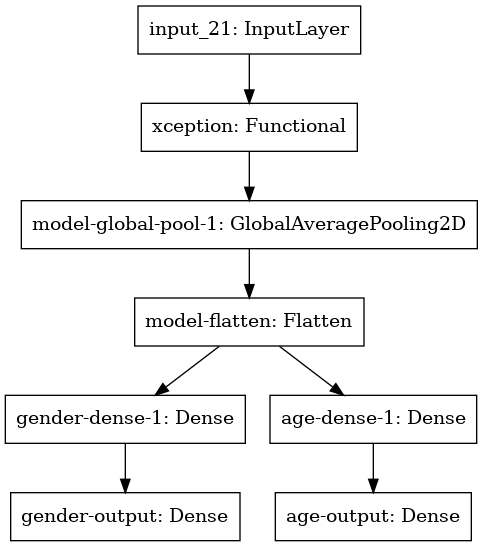

In [46]:
from tensorflow.keras.utils import plot_model
plot_model(model)

# Model Evaluation

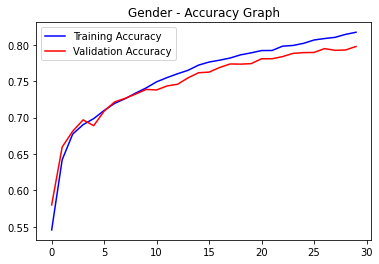

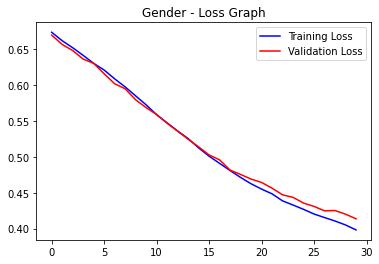

<Figure size 432x288 with 0 Axes>

In [47]:
acc = history.history['gender-output_accuracy']
val_acc = history.history['val_gender-output_accuracy']
epochs = range(len(acc))

plt.plot(epochs,acc,'b',label='Training Accuracy')
plt.plot(epochs,val_acc,'r',label='Validation Accuracy')
plt.title('Gender - Accuracy Graph')
plt.legend()
plt.figure()

loss = history.history['gender-output_loss']
val_loss = history.history['val_gender-output_loss']

plt.plot(epochs,loss,'b',label='Training Loss')
plt.plot(epochs,val_loss,'r',label='Validation Loss')
plt.title('Gender - Loss Graph')
plt.legend()
plt.figure()
plt.show()

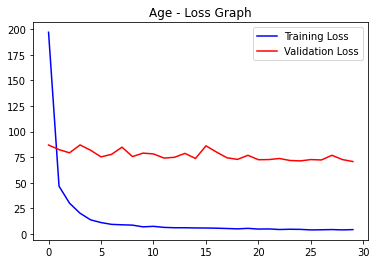

<Figure size 432x288 with 0 Axes>

In [48]:
# age model - regression
loss = history.history['age-output_loss']
val_loss = history.history['val_age-output_loss']
epochs = range(len(loss))

plt.plot(epochs,loss,'b',label='Training Loss')
plt.plot(epochs,val_loss,'r',label='Validation Loss')
plt.title('Age - Loss Graph')
plt.legend()
plt.figure()
plt.show()

# Prediction

Original Gender: Male Original Age: 29
Predicted Gender: Male Predicted Age: 29


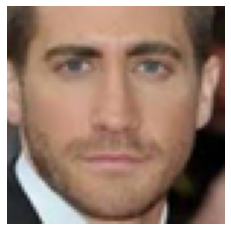

In [53]:
from math import *
image_index = 150
print('Original Gender:',gender_dict[y_gender[image_index]],'Original Age:',y_age[image_index])
pred = model.predict(X[image_index].reshape(1,75,75,3))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print('Predicted Gender:',pred_gender,'Predicted Age:',pred_age)
plt.imshow(X[image_index]);
plt.axis('off');

In [54]:
model.save('best_model.h5')